## Resumo Aula 3 ML3 ##

## Técnicas de Seleção de Atributos - parte 2

- *Wrapping*
- Principais técnicas de seleção de atributos por *wrapping*
- Demonstração com *Recursive Feature Elimination*
- Demonstração com Importância de Permutações - *permutation_importance*

## **1. Wrapping**

No método de envelopamento, *wrapping*, diferentes combinações de atributos são testadas em relação à alguma métrica de desempenho, e utilizando-se um modelo de machine learning. Depois do treinamento, o desempenho de todas os modelos treinados com as diferentes combinações de atributos é comparado, e seleciona-se aquela combinação que apresentar o melhor desempenho.

Apesar de utilizar o resultado de modelos, assim como as técnicas de *embedding*, as técnicas *wrapper* realizam a seleção dos atributos **durante o treinamento dos modelos**, enquanto que as técnicas **wrapper** realizam a seleção dos atributos **antes do treinamento iniciar**.

Os métodos mais conhecidos são:

* Forward selection - [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) <br>
* Backward elimination - [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html), [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) <br>
* Stepwise selection (Bi-directional elimination) - [SequentialFeatureSelector do mlxtend](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector)<br>
* Permutation Importance - [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)
<br><br>

### 1.1. **Foward Selection**

Etapas:

1) Começa com um modelo que não contém variáveis (chamado de Null Model)
2) Faz um modelo com cada uma das features separadamente
3) Escolhe a feature mais significativa
4) Roda modelos com a feature selecionada e adicionando mais uma
5) Escolhe o melhor modelo
6) Repete processo 4 e 5 até acabarem as features

<img src="https://quantifyinghealth.com/wp-content/uploads/2019/10/forward-stepwise-algorithm.png" text="https://quantifyinghealth.com/stepwise-selection/" width=400>


<br>

### 1.2. **Backward Selection**

Etapas:

1) Roda um modelo com todas as features
2) Escolhe a feaute menos significativa e elimina ela
3) Roda um modelo com as features restantes
4) Repete o processo 2 e 3 sequencialmente

A vantagem do Backward Selection é considerar a interação entre as features antes de eliminá-las, mas se o número de features for muito grande a seleção pode demorar demais.

<br>

 ### 1.3. **Bi-directional Elimination**

Muito semelhante ao Foward selection, mas ao adicionar uma nova variável ele verifica a importantância de todas as features e se encontrar alguma com significância menor que a determinada previamente, remove essa feature específica por meio do Backward Elimination.

Portanto, é uma combinação de seleção para frente e eliminação para trás.

Etapas:

1) Determine um nível de significância para adicionar e remover features do modelo (por exemplo, significancia_add = 0,05 e significancia_remove = 0,05 com 95% de confiança).

2) Execute a próxima etapa do Foward Selection (a feature recém-adicionada deve ter valor p-value < significancia_add para entrar).

3) Execute todas as etapas de eliminação para trás. Ou seja, qualquer recurso adicionado anteriormente com p-value > significancia_remove será removido do modelo).

4) Repita as etapas 2 e 3 até obtermos um conjunto final ótimo de recursos.


Para saber mais acesse o [link 1](https://quantifyinghealth.com/stepwise-selection/) e [link 2](https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/)

## **2. Recursive Feature Elimination(RFE)**

O RFE é um método que se utiliza de um estimador capaz de atribuir um score de **importância** a cada uma das features.

> Por exemplo, podemos olhar para os coeficientes de um modelo linear (`coef_`), ou então, para os scores de importância de features (`feature_importances_`). Esse método só irá funcionar se o estimador escolhido retorna `coef_` ou `feature_importances_`.

O método então considera recursivamente **subconjuntos cada vez menores de features**, da seguinte maneira:

- O estimador é treinado inicialmente com todas as features;
- A importância de cada uma das features é calculada;
- As features menos importantes são retiradas do conjunto de features;
- O processo recomeça, até que o número  desejado de features seja alcançado.

Sendo assim, temos dois hiperparâmetros importantes na classe [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html):

- `estimator`: o estimador que irá disponibilizar os scores de importância de features;
- `n_features_to_select`: a quantidade de features que o subconjunto final terá.

Na prática, podemos utilizar um gridsearch para otimizar estes dois hiperparâmetros, ou então utilizar a classe [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), que determina o melhor número de features automaticamente.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ignorar warnings
warnings.filterwarnings('ignore')

In [94]:
# carregando os dados
data = pd.read_csv('../datasets/breast_cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [95]:
# extraindo features
x = data.drop(['id', 'diagnosis','Unnamed: 32'], axis=1)
y = data[['diagnosis']]

# transformando feature de y
y.diagnosis = y.diagnosis.map({'M': 1, 'B': 0})

In [96]:
# separando em conjunto de treino e de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=19, stratify=y)

In [97]:
# instância e faz o fit com RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10).fit(x_train, y_train)

In [98]:
# support_ retorna uma máscara com as features selecionadas
rfe.support_

array([False,  True, False, False, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False,  True,  True,
        True, False, False])

In [99]:
x_train.iloc[:, rfe.support_].head(1).T

,138
texture_mean,17.57000
concavity_mean,0.15390
concave points_mean,0.08624
radius_se,1.29600
texture_worst,21.43000
perimeter_worst,121.40000
area_worst,971.40000
compactness_worst,0.21640
concavity_worst,0.33550
concave points_worst,0.16670


Mas e se eu não souber quantos atributos são bons para eu selecionar? Posso selecionar usando a classe [RFECV]((https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)).

In [100]:
# instancia StratifiedKFold

splitter = StratifiedKFold(n_splits=3)



In [101]:
# instancia e faz o fit com RFE
rfecv = RFECV(estimator=DecisionTreeClassifier(),
              scoring='f1',
              cv=splitter,
              ).fit(x_train, y_train)


results = pd.DataFrame(rfecv.grid_scores_)
results


,0
0,0.819398
1,0.892759
2,0.917248
3,0.907611
4,0.916988
5,0.910304
6,0.908781
7,0.912481
8,0.912481
9,0.919495


<hr>

**Exercício 1** Repita o exercício com o dataset `breast_cancer.csv` usando o algoritmo de LASSO para a seleção dos atributos. Realize a tunagem dos hiperparâmetros do estimador do RFE, do estimador base do AdaBoost e do próprio AdaBoost.

<hr>

In [102]:
data_bc = pd.read_csv('../datasets/breast_cancer.csv')
data_bc_clean = data_bc.drop(columns=['id','Unnamed: 32'])
data_bc

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [103]:
data_bc.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [104]:
# extraindo features
x = data.drop(['id', 'diagnosis','Unnamed: 32'], axis=1)
y = data[['diagnosis']]

# transformando feature de y
y.diagnosis = y.diagnosis.map({'M': 1, 'B': 0})

In [105]:
# como o dataset nao possui features categoricas, vou realizar apenas o tratamento de escalonar os dados
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

In [106]:
# separando em conjunto de treino e de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=19, stratify=y)

In [107]:
from sklearn.feature_selection import SelectFromModel
# configurando o pipeline do modelo
model_pipe = Pipeline([('scaler', StandardScaler()),
                       ('feature_selector', RFE(LogisticRegression(penalty='l1', solver='saga'))),
                       ('model', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))])

In [108]:
# Configurando o search
from sklearn.metrics import recall_score, make_scorer

params = {'feature_selector__n_features_to_select':range(1,x_train.shape[1]+1),
          'feature_selector__estimator__C': np.random.uniform(0.001, 1, 1000),
          'model__base_estimator__max_depth': range(1,10,1),
          'model__n_estimators':np.random.randint(20, 401, 200)}

score = {'recall': make_scorer(recall_score, pos_label=1)}

kf5 = StratifiedKFold(n_splits=5, shuffle=True)

model_selector = RandomizedSearchCV(estimator=model_pipe, param_distributions=params, n_iter=300, scoring=score, cv=kf5, n_jobs=-1, refit='recall')

In [109]:
model_selector.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('feature_selector',
                                              RFE(estimator=LogisticRegression(penalty='l1',
                                                                               solver='saga'))),
                                             ('model',
                                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'feature_selector_...
       181, 323, 321, 177, 247, 164, 316,  51, 186, 210, 373,  77,  87,
       130,  52, 363, 215, 383, 374, 183, 229, 232, 351, 349, 121, 153,
       330, 369,  29, 304, 287, 164, 191, 173, 342,  23,  39, 124,  48,
       367, 202, 152, 311, 137, 159, 122, 154, 297, 359, 161, 131, 118,
       244, 376, 240, 261, 1

In [11]:
from sklearn.metrics import confusion_matrix

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    '''função para exibir o resultado do treinamento e teste do modelo'''
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)
    
    cm = confusion_matrix(y_train, y_pred_train)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    print(display.plot())

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_test)
    display=ConfusionMatrixDisplay(confusion_matrix=cm)
    print(display.plot())

    print(classification_report(y_test, y_pred_test))


Métricas de avaliação de treino:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       148

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398


Métricas de avaliação de teste:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       107
           1       0.97      0.92      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



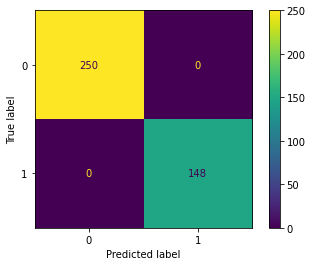

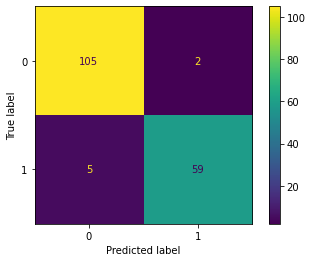

In [111]:
metricas_classificacao(model_selector.best_estimator_,X_train=x_train, X_test=x_test,y_train=y_train,y_test=y_test)

## **3. Importância de Permutações**

este método, utilizamos a função [`sklearn.inspection.permutation_importance()`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html), que vai criar permutações das features, mantendo um registro do score. O permutation_importance é definido como a diminuição no score de um modelo quando uma única feature é embaralhada aleatoriamente. Este procedimento quebra a relação entre a feature e o target e utiliza a queda na pontuação do modelo como um indicativo de quanto o modelo depende dessa feature.

Por realizar diversas permutações, este método é mais custoso, mas tem a vantagem de eliminar o viés que features de alta cardinalidade carregam com o método baseado em impureza.

Para maiores detalhes sobre o método, [clique aqui!](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

> Observação: este é um método que pode ser usado com qualquer estimador!

In [120]:
result_perm = permutation_importance(estimator=model_selector.best_estimator_, X=x_train, y=y_train, n_repeats=50)


In [121]:
# dicionário com importância média e os desvios pardão
results = {'importance':result_perm.importances_mean,
           'std_importance':result_perm.importances_std}

# criando o dataframe com os resultados

df_import = pd.DataFrame(data=results, index=x_train.columns).sort_values('importance', ascending=False)
df_import

,importance,std_importance
texture_mean,0.002211,0.002111
radius_mean,0.000000,0.000000
symmetry_worst,0.000000,0.000000
concave points_worst,0.000000,0.000000
concavity_worst,0.000000,0.000000
compactness_worst,0.000000,0.000000
smoothness_worst,0.000000,0.000000
area_worst,0.000000,0.000000
perimeter_worst,0.000000,0.000000
texture_worst,0.000000,0.000000


<hr>

**Exercício 2** Aplique o conceito do permutation_importances com árvores e com modelos lineares para o dataset `german_credit_data`. O estimador final será um GradientBoosting para ambos os casos.

<hr>

In [2]:
credit_data = pd.read_csv('../datasets/german_credit_data.csv')

In [4]:
credit_data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [14]:
credit_data.drop(columns='Unnamed: 0', inplace=True)
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [6]:
# Verificando classes das variaveis categoricas, e possivel concluir que existe certa ordem em cada uma delas. Hipotese: sendo nan, a ausencia de dinheiro na conta.
credit_data.Housing.unique()
credit_data['Saving accounts'].unique()
credit_data['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

Housing = ['own', 'free', 'rent']

Saving account = [nan, 'little', 'quite rich', 'rich', 'moderate']

Checking account = ['little', 'moderate', nan, 'rich']




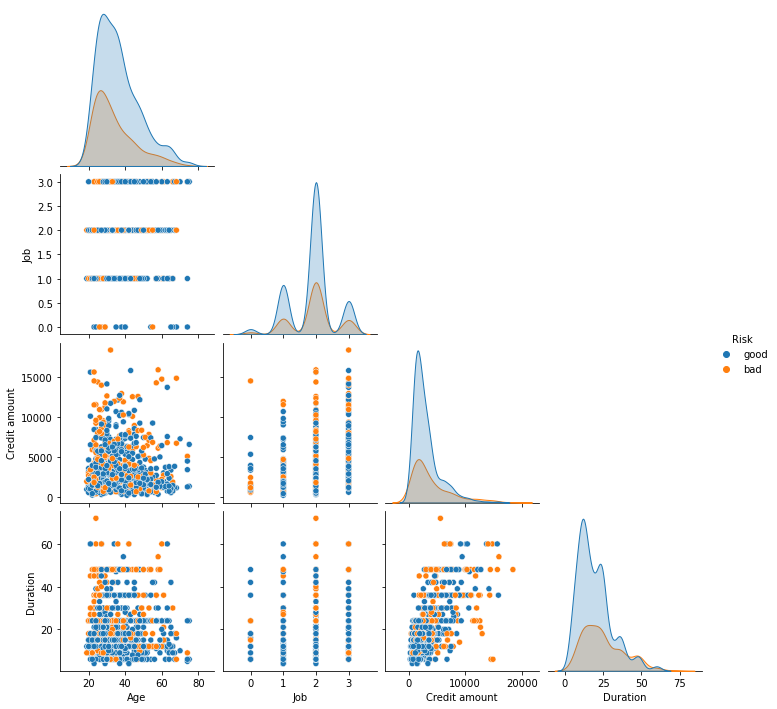

In [24]:
# Verificando a distribuicao das variaveis e correlacao com o target
sns.pairplot(credit_data, corner=True, hue='Risk')

<AxesSubplot:>

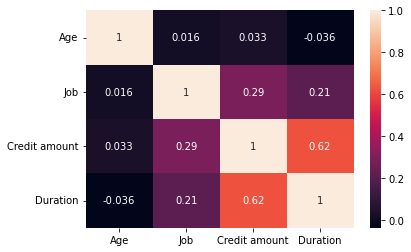

In [25]:
# A duracao do credito e a variavel mais correlacionada a quantidade de credito recebida
corr = credit_data.corr()

sns.heatmap(corr, annot=True)

In [15]:
x = credit_data.drop(columns='Risk')
y = credit_data['Risk']

y = y.map({'good': 1, 'bad': 0})



x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, shuffle=True, stratify=y)

In [16]:
# criando o pipeline de preprocessamento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

pipe_preprocessing = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='None')),
                               ('encoder', OneHotEncoder(drop='first'))])

cat_features = x.select_dtypes(exclude=np.number).columns.to_list()

preprocessing = ColumnTransformer([('cat_treat', pipe_preprocessing, cat_features)], remainder='passthrough')

In [17]:
# criando o pipeline do modelo final
from sklearn.ensemble import GradientBoostingClassifier
pipe_final = Pipeline([('preprocessing', preprocessing),
                       ('scaler', StandardScaler()),
                       ('feat_selection', RFE(LogisticRegression(penalty='l1', solver='saga'))),
                       ('model', GradientBoostingClassifier())])


In [19]:
# criando o search

params_dict = {'feat_selection__estimator__C': np.random.uniform(0.01, 1, 100),
               'feat_selection__n_features_to_select':range(3,x_train.shape[1]+1),
               'model__learning_rate': np.random.uniform(0.01, 1, 100),
               'model__n_estimators': np.random.randint(50,1000, 1000)}

kf5 = StratifiedKFold(n_splits=5, shuffle=True)

search = RandomizedSearchCV(estimator=pipe_final, param_distributions=params_dict, scoring='f1', refit='f1', n_jobs=-1, cv= kf5, n_iter=100, random_state=42)

In [20]:
search.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_treat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='None',
                                                                                                              strategy='constant')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                    

In [21]:
search.best_params_

{'model__n_estimators': 566,
 'model__learning_rate': 0.019882181587602105,
 'feat_selection__n_features_to_select': 9,
 'feat_selection__estimator__C': 0.7810331447835874}

In [22]:
search.best_score_

0.8258220903228718


Métricas de avaliação de treino:
              precision    recall  f1-score   support

           0       0.76      0.50      0.61       210
           1       0.81      0.93      0.87       490

    accuracy                           0.80       700
   macro avg       0.79      0.72      0.74       700
weighted avg       0.80      0.80      0.79       700


Métricas de avaliação de teste:
              precision    recall  f1-score   support

           0       0.50      0.30      0.37        90
           1       0.74      0.87      0.80       210

    accuracy                           0.70       300
   macro avg       0.62      0.59      0.59       300
weighted avg       0.67      0.70      0.67       300



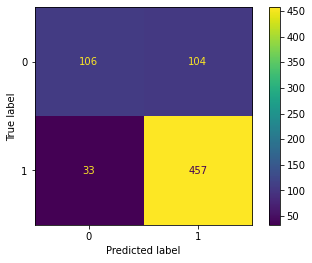

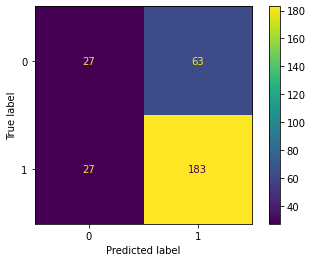

In [23]:
metricas_classificacao(search.best_estimator_,X_train=x_train, X_test=x_test,y_train=y_train,y_test=y_test)

In [24]:
result_perm = permutation_importance(estimator=search.best_estimator_, X=x_train, y=y_train, n_repeats=50)
# dicionário com importância média e os desvios pardão
results = {'importance':result_perm.importances_mean,
           'std_importance':result_perm.importances_std}

# criando o dataframe com os resultados

df_import = pd.DataFrame(data=results, index=x_train.columns).sort_values('importance', ascending=False)
df_import

,importance,std_importance
Checking account,0.096314,0.011278
Duration,0.083657,0.013432
Saving accounts,0.037514,0.007084
Sex,0.021000,0.006307
Housing,0.016200,0.006581
Purpose,0.014429,0.005615
Age,0.000000,0.000000
Job,0.000000,0.000000
Credit amount,0.000000,0.000000


<BarContainer object of 9 artists>

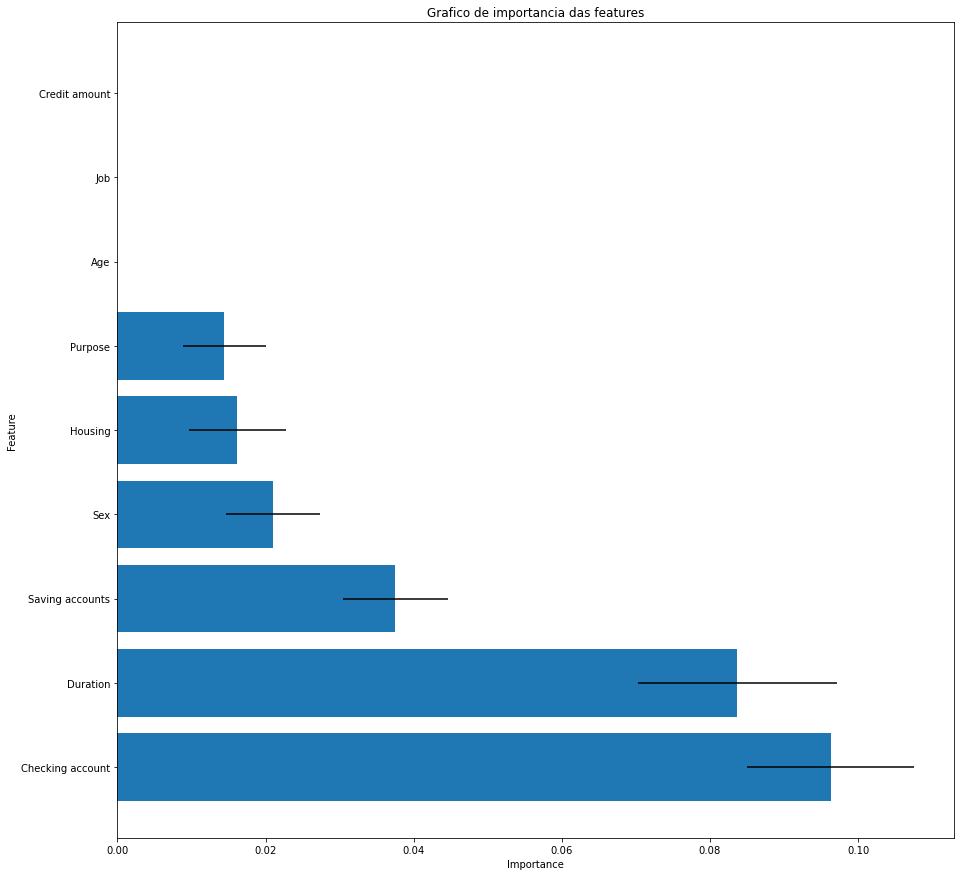

In [31]:
plt.figure(figsize=(15,15))
plt.title('Grafico de importancia das features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.barh(width=df_import['importance'], y = df_import.index, xerr=df_import['std_importance'])